In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import random

In [2]:
# set seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # 如果使用CUDA
np.random.seed(seed)
random.seed(seed)

In [3]:
from importlib import reload
import data_utils 
reload(data_utils)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model_name = "cvcl_res"
model, preprocess = data_utils.get_model(model_name, device)

Loading CVCL


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


Successfully load CVCL-resnext50


In [4]:
dataset_name = "cub_test"
data = data_utils.get_data(dataset_name, preprocess, get_attr=False)
dataloader = DataLoader(data, batch_size=32, shuffle=False)

In [5]:
class_names = data.classes['class_name'].tolist()
clean_cls = [name.split(".")[1] for name in class_names]
#TODO: maybe not that cleaned due to "_"
print(clean_cls)

['Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani', 'Crested_Auklet', 'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Yellow_headed_Blackbird', 'Bobolink', 'Indigo_Bunting', 'Lazuli_Bunting', 'Painted_Bunting', 'Cardinal', 'Spotted_Catbird', 'Gray_Catbird', 'Yellow_breasted_Chat', 'Eastern_Towhee', 'Chuck_will_Widow', 'Brandt_Cormorant', 'Red_faced_Cormorant', 'Pelagic_Cormorant', 'Bronzed_Cowbird', 'Shiny_Cowbird', 'Brown_Creeper', 'American_Crow', 'Fish_Crow', 'Black_billed_Cuckoo', 'Mangrove_Cuckoo', 'Yellow_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Purple_Finch', 'Northern_Flicker', 'Acadian_Flycatcher', 'Great_Crested_Flycatcher', 'Least_Flycatcher', 'Olive_sided_Flycatcher', 'Scissor_tailed_Flycatcher', 'Vermilion_Flycatcher', 'Yellow_bellied_Flycatcher', 'Frigatebird', 'Northern_Fulmar', 'Gadwall', 'American_Goldfinch', 'European_Goldfinch', 'Boat_tailed_Grackle', 'Eared_

In [6]:
from tqdm import tqdm
import clip

def zs_predict(model_name, model, dataloader, class_names, device):
    """
    Set model to eval and evaluate zero-shot classification acc,
    return predic labels based on given class_names
    """
    model.eval()
    all_values = [] # similarity values
    all_preds = [] # predicted labels
    all_labels = [] # ground truth labels

    with torch.no_grad():
        if "cvcl" in model_name:
            txt_tokens = [model.tokenize(f"a photo of a {c}") for c in class_names]
            txt_input  = torch.cat([txt[0] for txt in txt_tokens]).to(device)
            txt_len = torch.cat([txt[1] for txt in txt_tokens]).to(device)
            txt_feature = model.encode_text(txt_input, txt_len)
        
        elif "clip" in model_name:
            txt_input = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
            txt_feature = model.encode_text(txt_input)
            
        txt_feature /= txt_feature.norm(dim=-1, keepdim=True)

        for img, label in tqdm(dataloader, desc="Evaluating"):
            imgs = img.to(device)
            labels = label.to(device)

            #! which is a more arbitrary way
            # without considering normalize feature length
            # similarity = torch.matmul(image_features, text_features.T)
            # preds = similarity.argmax(dim=1)

            img_feature = model.encode_image(imgs)
            img_feature /= img_feature.norm(dim=-1, keepdim=True)
            txt_feature /= txt_feature.norm(dim=-1, keepdim=True)
            similarity = (100.0 * img_feature @ txt_feature.T).softmax(dim=-1)
            indices = similarity.argmax(dim=-1)
            # values, indices = similarity[0].topk(1)

            # all_values.extend(values.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(indices.cpu().numpy())
            # for index in indices:
            #     all_preds.append(class_names[index.item()]) 

    return all_values, all_preds, all_labels

In [7]:
values, predictions, gt_labels = zs_predict(model_name, model, dataloader, clean_cls, device)

Evaluating: 100%|██████████| 182/182 [02:18<00:00,  1.32it/s]


In [14]:
print(predictions[:10])
print(gt_labels[:10])

[0, 3, 37, 45, 36, 0, 0, 29, 4, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
print(len(predictions), len(gt_labels))

5794 5794


In [16]:
# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(gt_labels, predictions)
precision = precision_score(gt_labels, predictions, average='macro')
recall = recall_score(gt_labels, predictions, average='macro')
f1 = f1_score(gt_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.0038
Precision: 0.0004
Recall: 0.0040
F1 Score: 0.0007


/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/tmp/ipykernel_90278/3525310814.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/tmp/ipykernel_90278/3525310814.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


     Model  Accuracy  Precision    Recall  F1 Score
0  Model A       0.8   0.833333  0.833333  0.800000
1  Model B       0.8   0.875000  0.750000  0.761905


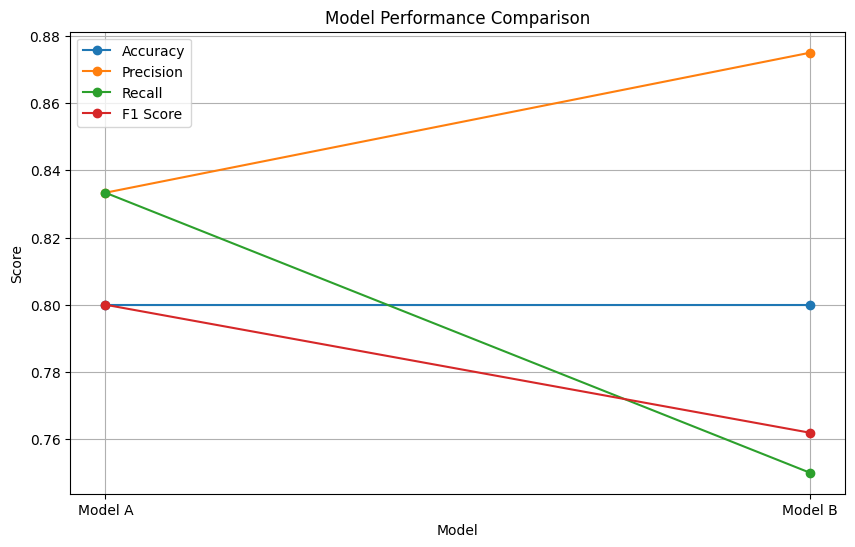

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    
    return accuracy, precision, recall, f1

# Example data from different models
model_results = {
    'Model A': {
        'true_labels': [1, 0, 1, 1, 0],
        'predictions': [1, 0, 1, 0, 0]
    },
    'Model B': {
        'true_labels': [1, 0, 1, 1, 0],
        'predictions': [1, 1, 1, 1, 0]
    }
    # Add more models as needed
}

# Create a DataFrame to store the results
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for model_name, data in model_results.items():
    accuracy, precision, recall, f1 = calculate_metrics(data['true_labels'], data['predictions'])
    df_results = df_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, ignore_index=True)

print(df_results)

# Plotting the results
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.plot(df_results['Model'], df_results[metric], marker='o', label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()